In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import train
import network_unet as unet
import network_hed as hed
import torch

#reimport
import evaluation as eval
import importlib
importlib.reload(eval)

import utils

In [68]:
# Test data
target_pos = 4

test_file = '../data/SIVE/test_1/'
test_paths = glob.glob(test_file + '*.npy')
test_targets = [np.load(file)[target_pos] for file in test_paths]
test_input = [np.load(file)[0:target_pos] for file in test_paths]

print("Test dimensions:")
print(np.shape(test_targets[0]))
print(np.shape(test_input[0]))

# Points dictionary
points_dict = np.load('../data/SIVE/points_dict.npy', allow_pickle=True).item()
points_dict['20240623T114351_tramore'][1][0]


Test dimensions:
(900, 1000)
(4, 900, 1000)


(336, 262)

In [69]:
model_file = "../models/SIVE_02JUN2025/"
model_paths = glob.glob(model_file + '*.pth')
print("Model files found:")
print(model_paths)

Model files found:
['../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_BigEarthNet_False_DICE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_BigEarthNet_False_wBCE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_BigEarthNet_True_DICE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_SimpleCNN_False_wBCE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_ImageNet_False_wBCE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_ImageNet_True_wBCE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_SimpleCNN_False_DICE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_BigEarthNet_True_wBCE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_ImageNet_False_DICE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_ImageNet_True_DICE.pth']


In [70]:
def get_model(model_path):

    model_name = os.path.basename(model_path)
    print(f"Loading model: {model_name}")

    # Get metadata
    name_split = model_name.split('_')
    date = name_split[1]
    model_type = name_split[2]
    backbone_type = name_split[3]
    freeze_backbone = name_split[4]
    loss_function = name_split[5]

    device = torch.device('mps')  #UPDATE

    # Load model
    if model_type == 'unet':
        pass
    elif model_type == 'HED':
        if backbone_type == 'SimpleCNN':
            backbone = hed.SimpleCNNBackbone(in_channels=4)
        else:
            # Use ResNet50 backbone for ImageNet or BigEarthNet
            backbone = hed.ResNet50Backbone(in_channels=4,
                                        backbone_dataset=backbone_type)
    
        model = hed.HED(backbone=backbone, out_channels=1)

    state_dict = torch.load(model_path, map_location=torch.device('cpu') )
    model.load_state_dict(state_dict)
    model.eval()
    model.to(device)

    meta_data = {
        'name': model_name,
        'date': date,
        'arcitecture': model_type,
        'backbone': backbone_type,
        'freeze_backbone': freeze_backbone,
        'loss_function': loss_function
    }

    return model, meta_data

In [76]:
points.keys()

dict_keys([1.0, 2.0, 3.0])

Processing file: 20220323T113321_portrane
Image shape: (5, 750, 650)
Number of crops: 7


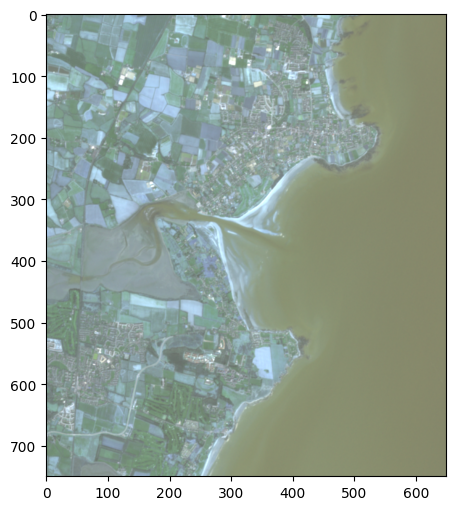

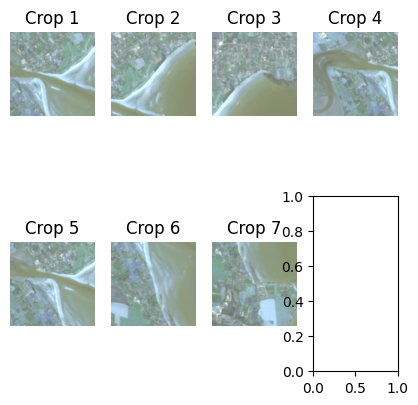

In [80]:
def get_iterative_crops(image, points, crop_size=144,temp_location="../data/SIVE/crops/"):
    """
    Get crops from the image based on the points provided.
    The crops are centered around the points and have a fixed size.
    Args:
        image (numpy.ndarray): The input image from which to extract crops.
        points (list of tuples): List of (x, y) coordinates around which to crop.
        crop_size (int): The size of the crops to extract (assumed square).
    """

   
    os.makedirs(temp_location, exist_ok=True)

    crop_paths = []
    start_points = []
    count = 0
    for key in points:
        for point in points[key]:
            x, y = point
        
            x_start = max(0, x - crop_size // 2)
            x_end = min(image.shape[2], x + crop_size // 2)
            y_start = max(0, y - crop_size // 2)
            y_end = min(image.shape[1], y + crop_size // 2)

            crop = image[:,y_start:y_end, x_start:x_end]
            assert crop.shape == (5,crop_size, crop_size), f"Crop shape mismatch: {crop.shape} != ({crop_size}, {crop_size})"

            # Save the crop to a temporary location
            # We do this as it is easier to use existing code that expects file paths
            # aka too lazy to change the code
            crop_path = os.path.join(temp_location, f"crop_{count+1}.npy")
            np.save(crop_path, crop)
            crop_paths.append(crop_path)
            start_points.append((x_start, y_start))
            count += 1
    
    return crop_paths,start_points

path = test_paths[1]
ID = os.path.basename(path).split('.')[0]
print(f"Processing file: {ID}")
image = np.load(path)
print(f"Image shape: {image.shape}")
points = points_dict[ID]

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

rgb_image = utils.get_rgb(image,contrast=0.3)
ax.imshow(rgb_image)

crop_paths, start_points = get_iterative_crops(image, points)
print(f"Number of crops: {len(crop_paths)}")

fig,ax = plt.subplots(2, 4, figsize=(5, 5))
ax = ax.flatten()
for i, crop in enumerate(crop_paths):
    crop = np.load(crop)
    rgb_crop = utils.get_rgb(crop, contrast=0.3)
    ax[i].imshow(rgb_crop)
    ax[i].set_title(f"Crop {i+1}",)
    ax[i].axis('off')

In [81]:
def combine_crops(crop_preds, start_points, image,crop_size=144):
    """
    Combine crops into a single image.
    Args:
        crop_paths (list of str): List of paths to the crop files.
        start_points (list of tuples): List of (x_start, y_start) coordinates for each crop.
        image_shape (tuple): Shape of the original image to fit the crops into.
    Returns:
        numpy.ndarray: Combined image with crops placed at their respective positions.
    """
    H = image.shape[1]
    W = image.shape[2]
    combined_pred = np.zeros((H, W), dtype=np.float32)

    for i, crop_pred in enumerate(crop_preds):
        x_start, y_start = start_points[i]
        combined_pred[ y_start:y_start+crop_size, x_start:x_start+crop_size] += crop_pred
    combined_pred= np.clip(combined_pred, 0, 1)

    assert combined_pred.shape == (H, W), f"Combined image shape mismatch: {combined_pred.shape} != ({H}, {W})"
    assert np.all(combined_pred >= 0) and np.all(combined_pred <= 1), "Combined image values out of bounds [0, 1]"

    
    return combined_pred

Loading model: SIVE_02JUN2025_HED_BigEarthNet_False_DICE.pth

Using BigEarthNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]



Text(0.5, 1.0, 'Prediction')

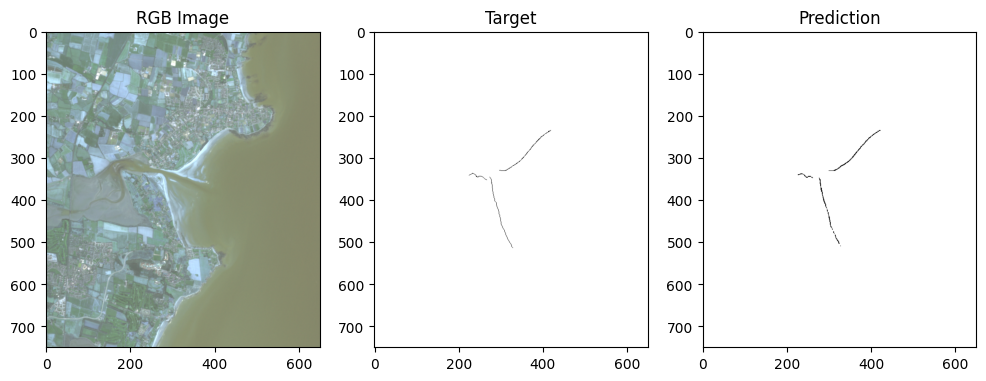

In [82]:
crop_paths, start_points = get_iterative_crops(image, points)
model_path = '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_BigEarthNet_False_DICE.pth'
model, meta_data = get_model(model_path)

crop_targets, crop_preds = eval.get_preds(model,crop_paths,batch_size=1)

combined_pred = combine_crops(crop_preds, start_points, image)



fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax[0].imshow(rgb_image)
ax[0].set_title("RGB Image")

ax[1].imshow(1-image[4], cmap='gray')
ax[1].set_title("Target")

ax[2].imshow(1-combined_pred, cmap='gray')
ax[2].set_title("Prediction")

Text(0.5, 1.0, 'Post-processed Prediction')

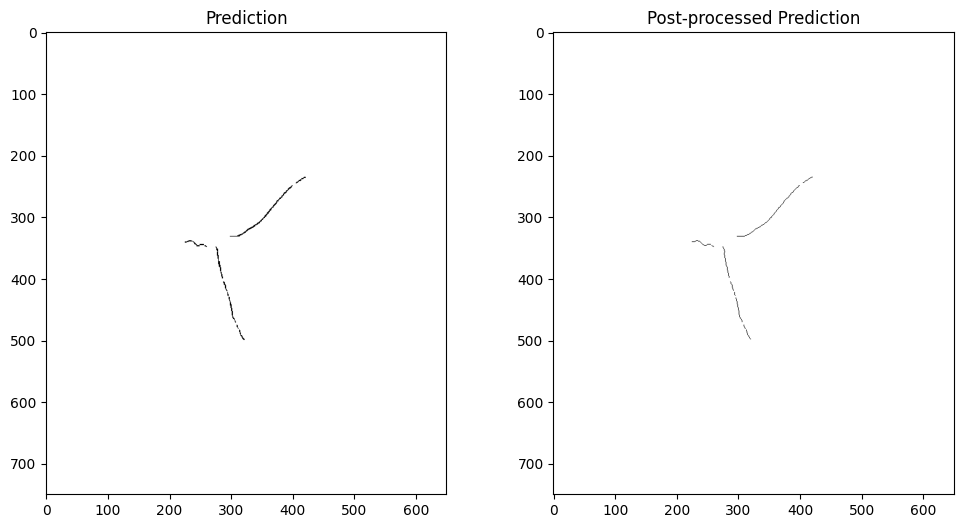

In [84]:
import numpy as np
import cv2
from skimage.morphology import skeletonize
from scipy.spatial import distance

def postprocess_edge_map(edge_map, connect_distance=None):
    """
    Post-process a 2D binary edge map:
    1. Apply thinning to reduce edge width to 1 pixel.
    2. Connect nearby disjoint edge segments using interpolation.

    Parameters:
    - edge_map (np.ndarray): 2D binary array (values 0 or 1).
    - connect_distance (int): Max pixel distance between endpoints to connect.

    Returns:
    - np.ndarray: Post-processed binary edge map (values 0 or 1).
    """
    # Step 1: Thinning
    binary = edge_map > 0
    thinned = skeletonize(binary).astype(np.uint8)

    # Step 2: Connect nearby endpoints
    if connect_distance is not None:
        
        coords = np.column_stack(np.where(thinned > 0))
        dist_matrix = distance.squareform(distance.pdist(coords))

        for i in range(len(coords)):
            for j in range(i + 1, len(coords)):
                if dist_matrix[i, j] < connect_distance:
                    pt1 = tuple(coords[i][::-1])  # (x, y)
                    pt2 = tuple(coords[j][::-1])
                    cv2.line(thinned, pt1, pt2, color=1, thickness=1)

    return thinned
   

pred_full_alt = combined_pred.copy()
pred_full_alt[400:405,:] = 0 
pred_full_alt[500:520,:] = 0
pred_full_alt[:,400:405] = 0  # Simulate a gap in the edge map for testing

processed_pred_full = postprocess_edge_map(pred_full_alt)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(1-pred_full_alt, cmap='gray')
ax[0].set_title("Prediction")
ax[1].imshow(1-processed_pred_full, cmap='gray')
ax[1].set_title("Post-processed Prediction")

In [101]:
def get_combined_pred(model, path, batch_size=1):
    """
    Get predictions for all test images.
    Args:
        model: The trained model.
        test_paths (list): List of paths to test images.
        batch_size (int): Batch size for prediction.
    Returns:
        list: List of predictions for each image.
    """
    
    image = np.load(path)

    ID = os.path.basename(path).split('.')[0]
    points = points_dict[ID]

    crop_paths, start_points = get_iterative_crops(image, points)
    target_crops, pred_crops = eval.get_preds(model, crop_paths, batch_size=1)

    combined_pred = combine_crops(pred_crops, start_points, image)
    combined_target = combine_crops(target_crops, start_points, image)

    assert np.array_equal(combined_target, image[4]), "Combined target does not match original image target"

    processed_pred = postprocess_edge_map(combined_pred)

    return image, processed_pred
        

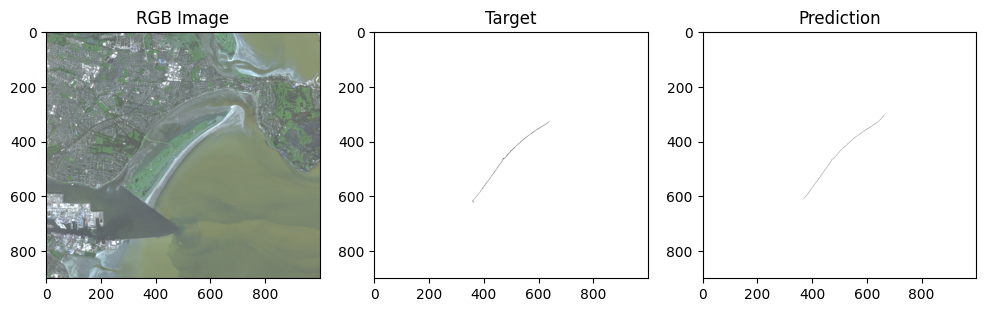

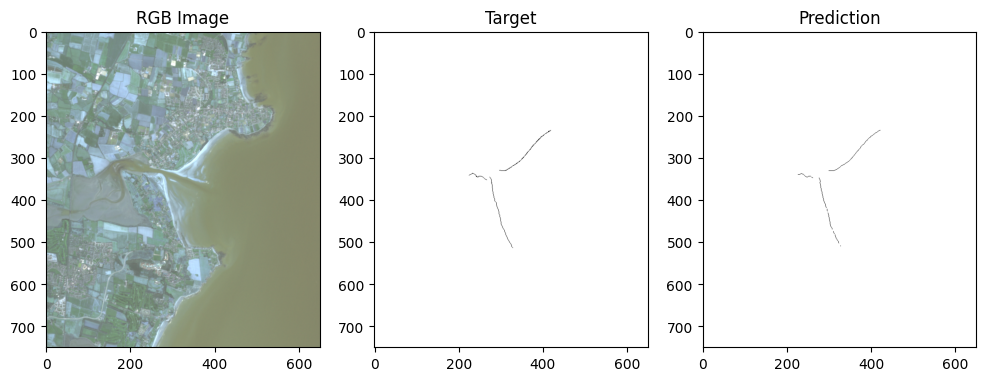

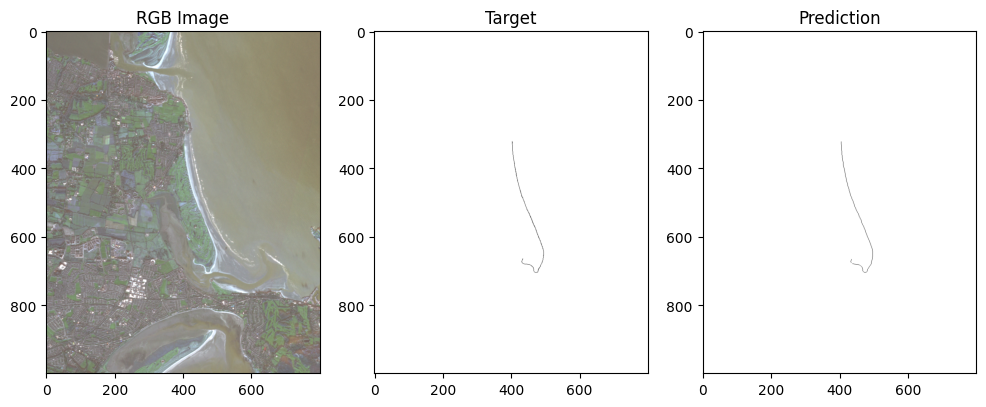

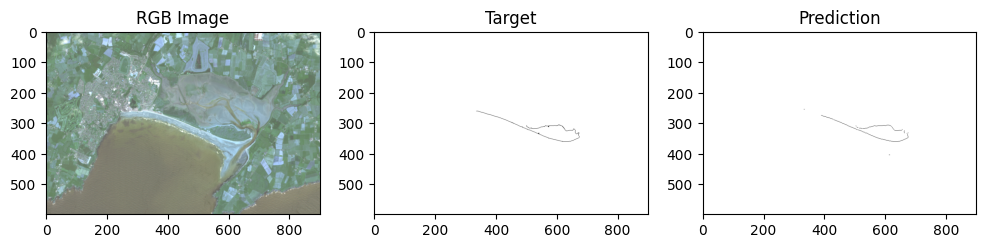

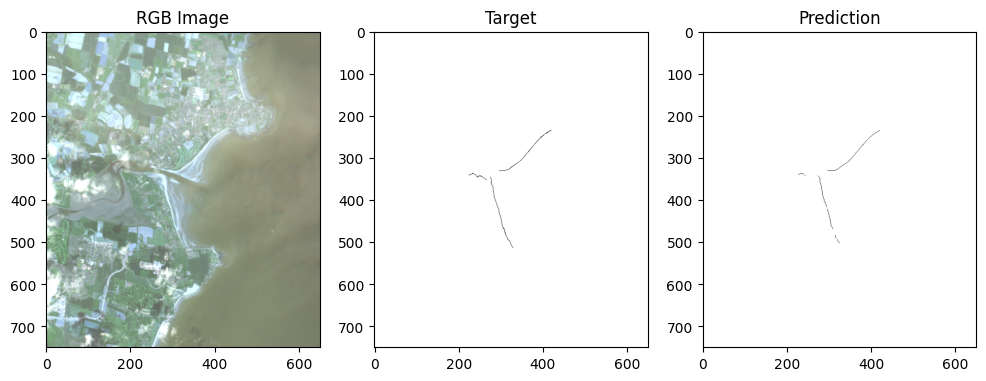

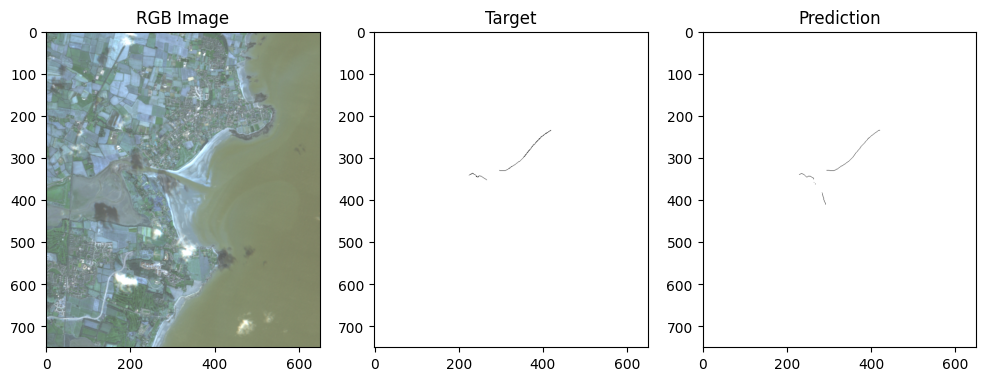

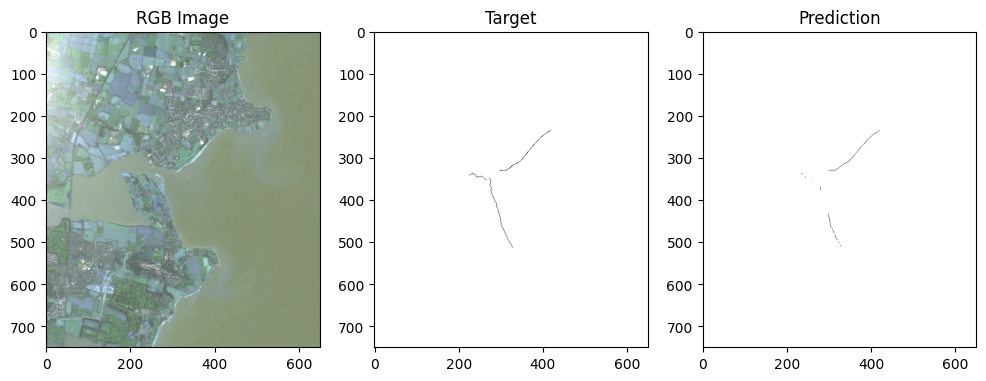

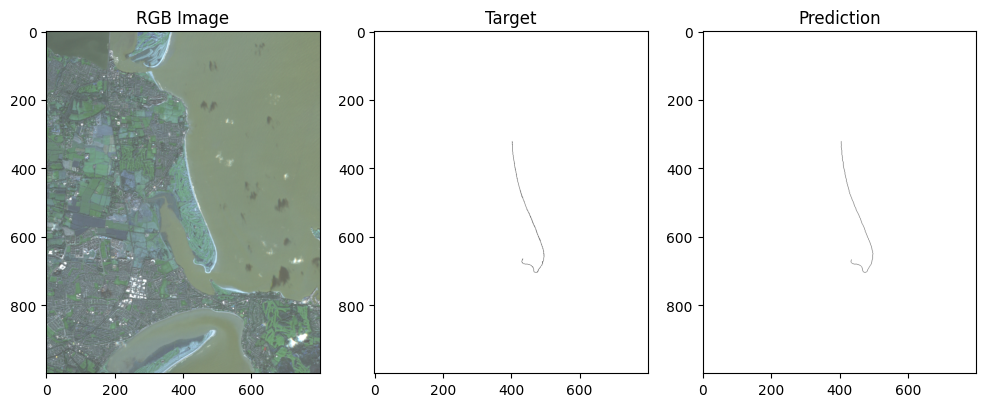

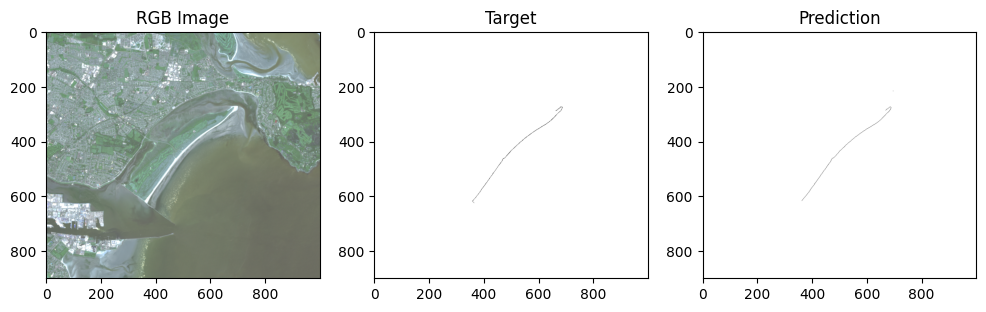

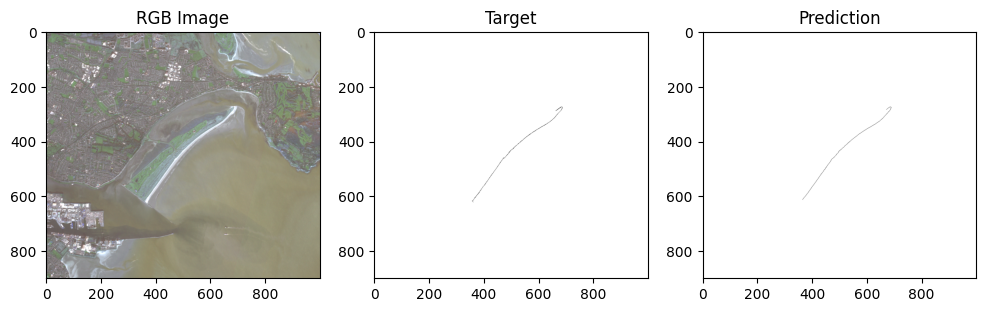

In [107]:
targets = []
preds = []

for path in test_paths:
    image,  pred_full = get_combined_pred(model, path, batch_size=1)

    targets.append(image[4])
    preds.append(pred_full)

    ID = os.path.basename(path).split('.')[0]
    points = points_dict[ID][1]

    fig, ax = plt.subplots(1, 3, figsize=(12, 6))
    rgb_image = utils.get_rgb(image, contrast=0.3)
    ax[0].imshow(rgb_image)
    ax[0].set_title("RGB Image")
    
    ax[1].imshow(1-image[4], cmap='gray')
    ax[1].set_title("Target")

    ax[2].imshow(1-pred_full, cmap='gray')
    ax[2].set_title("Prediction")
    
    plt.show()

In [104]:
test_metrics, test_arr = eval.eval_metrics(targets, preds)
print("Test Metrics:")
for key, value in test_metrics.items():
    print(f"{key}: {value:.4f}")

Test Metrics:
accuracy: 0.9995
precision: 0.7000
recall: 0.5410
f1: 0.6082
iou: 0.4400
fom: 0.7317


In [108]:
def get_all_results(model_paths, test_paths):
    results = []
    for model_path in model_paths:
        print(f"Processing model: {model_path}")

        model, meta_data = get_model(model_path)
        
        targets = []
        preds = []

        for path in test_paths:
            image,  pred_full = get_combined_pred(model, path, batch_size=1)

            targets.append(image[-1])
            preds.append(pred_full)

        test_metrics, test_arr = eval.eval_metrics(targets, preds)

        row = meta_data | test_metrics
        results.append(row)
        
    return results

In [109]:
results = get_all_results(model_paths, test_paths)
results_df = pd.DataFrame(results)
results_df

Processing model: ../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_BigEarthNet_False_DICE.pth
Loading model: SIVE_02JUN2025_HED_BigEarthNet_False_DICE.pth

Using BigEarthNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]

Processing model: ../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_BigEarthNet_False_wBCE.pth
Loading model: SIVE_02JUN2025_HED_BigEarthNet_False_wBCE.pth

Using BigEarthNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]

Processing model: ../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_BigEarthNet_True_DICE.pth
Loading model: SIVE_02JUN2025_HED_BigEarthNet_True_DICE.pth

Using BigEarthNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]

Processing model: ../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_SimpleCNN_False_wBCE.pth
Loading model: SIVE_02JUN2025_HED_SimpleCNN_False_wBCE.pth
Side channels: [64, 128, 256, 512, 512]

Processing model: ../models/SIVE_02JUN2025/SIVE

/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:163: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP_ / (TP_ + FP_)


Processing model: ../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_BigEarthNet_True_wBCE.pth
Loading model: SIVE_02JUN2025_HED_BigEarthNet_True_wBCE.pth

Using BigEarthNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]

Processing model: ../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_ImageNet_False_DICE.pth
Loading model: SIVE_02JUN2025_HED_ImageNet_False_DICE.pth

Using ImageNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]

Processing model: ../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_ImageNet_True_DICE.pth
Loading model: SIVE_02JUN2025_HED_ImageNet_True_DICE.pth

Using ImageNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]



,name,date,arcitecture,backbone,freeze_backbone,loss_function,accuracy,precision,recall,f1,iou,fom
0,SIVE_02JUN2025_HED_BigEarthNet_False_DICE.pth,02JUN2025,HED,BigEarthNet,False,DICE.pth,0.999517,0.699975,0.541011,0.608151,0.440024,0.731684
1,SIVE_02JUN2025_HED_BigEarthNet_False_wBCE.pth,02JUN2025,HED,BigEarthNet,False,wBCE.pth,0.999398,0.581619,0.530448,0.553601,0.386958,0.803600
2,SIVE_02JUN2025_HED_BigEarthNet_True_DICE.pth,02JUN2025,HED,BigEarthNet,True,DICE.pth,0.999433,0.621611,0.521324,0.566271,0.399400,0.712368
3,SIVE_02JUN2025_HED_SimpleCNN_False_wBCE.pth,02JUN2025,HED,SimpleCNN,False,wBCE.pth,0.999357,0.545702,0.537304,0.539159,0.373473,0.778346
4,SIVE_02JUN2025_HED_ImageNet_False_wBCE.pth,02JUN2025,HED,ImageNet,False,wBCE.pth,0.999380,0.572475,0.549020,0.558726,0.391961,0.791172
5,SIVE_02JUN2025_HED_ImageNet_True_wBCE.pth,02JUN2025,HED,ImageNet,True,wBCE.pth,0.998743,0.313115,0.461458,0.362707,0.227116,0.551004
6,SIVE_02JUN2025_HED_SimpleCNN_False_DICE.pth,02JUN2025,HED,SimpleCNN,False,DICE.pth,0.999299,0.000000,0.000000,0.000000,0.000000,0.000000
7,SIVE_02JUN2025_HED_BigEarthNet_True_wBCE.pth,02JUN2025,HED,BigEarthNet,True,wBCE.pth,0.998003,0.189080,0.431041,0.254242,0.148103,0.388293
8,SIVE_02JUN2025_HED_ImageNet_False_DICE.pth,02JUN2025,HED,ImageNet,False,DICE.pth,0.999495,0.674495,0.527433,0.590570,0.422337,0.730294
9,SIVE_02JUN2025_HED_ImageNet_True_DICE.pth,02JUN2025,HED,ImageNet,True,DICE.pth,0.999408,0.593670,0.509151,0.547178,0.383826,0.713861


# Evaluation with image crops

In [266]:
# Test data
target_pos = 4

test_file = '../data/SIVE/test_1/'
test_paths = glob.glob(test_file + '*.npy')
test_targets = [np.load(file)[target_pos] for file in test_paths]
test_input = [np.load(file)[0:target_pos] for file in test_paths]

print("Test dimensions:")
print(np.shape(test_targets))
print(np.shape(test_input))

Test dimensions:
(901, 144, 144)
(901, 4, 144, 144)


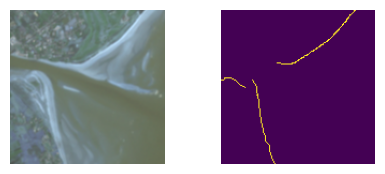

In [267]:
i = np.random.randint(0,len(test_paths))
rgb = utils.get_rgb(test_input[i],contrast=0.4)
target = test_targets[i]

fig, ax = plt.subplots(1,2,figsize=(5,2))
ax[0].imshow(rgb)
ax[1].imshow(target)

for a in ax:
    a.axis('off')

In [268]:
model_file = "../models/SIVE_02JUN2025/"
model_paths = glob.glob(model_file + '*.pth')
print("Model files found:")
print(model_paths)

Model files found:
['../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_BigEarthNet_False_DICE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_BigEarthNet_False_wBCE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_BigEarthNet_True_DICE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_SimpleCNN_False_wBCE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_ImageNet_False_wBCE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_ImageNet_True_wBCE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_SimpleCNN_False_DICE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_BigEarthNet_True_wBCE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_ImageNet_False_DICE.pth', '../models/SIVE_02JUN2025/SIVE_02JUN2025_HED_ImageNet_True_DICE.pth']


In [ ]:
# Helper functions 



def get_all_results(model_paths, test_paths):
    results = []
    for model_path in model_paths:
        model, meta_data = get_model(model_path)

        targets, test_preds = eval.get_preds(model,test_paths,batch_size=10)
        test_metrics, test_arr = eval.eval_metrics(test_targets, test_preds)

        row = meta_data | test_metrics
        results.append(row)
        
    return results

In [270]:
results = get_all_results(model_paths, test_paths)
results_df = pd.DataFrame(results)

Loading model: SIVE_02JUN2025_HED_BigEarthNet_False_DICE.pth

Using BigEarthNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]



/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:163: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP_ / (TP_ + FP_)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:165: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:164: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP_ / (TP_ + FN_)


Loading model: SIVE_02JUN2025_HED_BigEarthNet_False_wBCE.pth

Using BigEarthNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]



/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:164: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP_ / (TP_ + FN_)


Loading model: SIVE_02JUN2025_HED_BigEarthNet_True_DICE.pth

Using BigEarthNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]



/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:165: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:164: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP_ / (TP_ + FN_)


Loading model: SIVE_02JUN2025_HED_SimpleCNN_False_wBCE.pth
Side channels: [64, 128, 256, 512, 512]

Loading model: SIVE_02JUN2025_HED_ImageNet_False_wBCE.pth

Using ImageNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]



/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:165: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:164: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP_ / (TP_ + FN_)


Loading model: SIVE_02JUN2025_HED_ImageNet_True_wBCE.pth

Using ImageNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]



/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:164: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP_ / (TP_ + FN_)


Loading model: SIVE_02JUN2025_HED_SimpleCNN_False_DICE.pth
Side channels: [64, 128, 256, 512, 512]



/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:163: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP_ / (TP_ + FP_)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:166: RuntimeWarning: invalid value encountered in scalar divide
  iou = TP_ / (TP_ + FP_ + FN_)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:119: RuntimeWarning: invalid value encountered in scalar divide
  fom /= np.maximum(np.count_nonzero(img), np.count_nonzero(ref_img))


Loading model: SIVE_02JUN2025_HED_BigEarthNet_True_wBCE.pth

Using BigEarthNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]



/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:164: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP_ / (TP_ + FN_)


Loading model: SIVE_02JUN2025_HED_ImageNet_False_DICE.pth

Using ImageNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]



/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:165: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:163: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP_ / (TP_ + FP_)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:164: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP_ / (TP_ + FN_)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:166: RuntimeWarning: invalid value encountered in scalar divide
  iou = TP_ / (TP_ + FP_ + FN_)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:119: RuntimeWarning: invalid value encountered

Loading model: SIVE_02JUN2025_HED_ImageNet_True_DICE.pth

Using ImageNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]



/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:163: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP_ / (TP_ + FP_)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:165: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:164: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP_ / (TP_ + FN_)


In [271]:
results_df.drop(columns=['name','date']).sort_values(by=['arcitecture','backbone','freeze_backbone','loss_function'], ascending=False)

,arcitecture,backbone,freeze_backbone,loss_function,accuracy,precision,recall,f1,iou,fom
3,HED,SimpleCNN,False,wBCE.pth,0.984806,0.307887,0.990375,0.466723,0.307081,0.853162
6,HED,SimpleCNN,False,DICE.pth,0.993144,0.000000,0.000000,0.000000,0.000000,0.000000
5,HED,ImageNet,True,wBCE.pth,0.968758,0.184361,0.991124,0.306631,0.184217,0.681837
9,HED,ImageNet,True,DICE.pth,0.992473,0.465307,0.765488,0.570354,0.409208,0.861617
4,HED,ImageNet,False,wBCE.pth,0.981103,0.263218,0.990438,0.413578,0.262665,0.836403
8,HED,ImageNet,False,DICE.pth,0.994374,0.556914,0.721830,0.617732,0.461763,0.885567
7,HED,BigEarthNet,True,wBCE.pth,0.950335,0.132046,0.996678,0.229087,0.132020,0.564425
2,HED,BigEarthNet,True,DICE.pth,0.993480,0.508890,0.733757,0.593552,0.434286,0.866708
1,HED,BigEarthNet,False,wBCE.pth,0.984539,0.304583,0.982190,0.462294,0.302716,0.867830
0,HED,BigEarthNet,False,DICE.pth,0.994436,0.565645,0.720104,0.622551,0.463816,0.898835


In [272]:
best_models = results_df.drop(columns=['date']).sort_values(by=['fom'], ascending=False)
best_models

,name,arcitecture,backbone,freeze_backbone,loss_function,accuracy,precision,recall,f1,iou,fom
0,SIVE_02JUN2025_HED_BigEarthNet_False_DICE.pth,HED,BigEarthNet,False,DICE.pth,0.994436,0.565645,0.720104,0.622551,0.463816,0.898835
8,SIVE_02JUN2025_HED_ImageNet_False_DICE.pth,HED,ImageNet,False,DICE.pth,0.994374,0.556914,0.721830,0.617732,0.461763,0.885567
1,SIVE_02JUN2025_HED_BigEarthNet_False_wBCE.pth,HED,BigEarthNet,False,wBCE.pth,0.984539,0.304583,0.982190,0.462294,0.302716,0.867830
2,SIVE_02JUN2025_HED_BigEarthNet_True_DICE.pth,HED,BigEarthNet,True,DICE.pth,0.993480,0.508890,0.733757,0.593552,0.434286,0.866708
9,SIVE_02JUN2025_HED_ImageNet_True_DICE.pth,HED,ImageNet,True,DICE.pth,0.992473,0.465307,0.765488,0.570354,0.409208,0.861617
3,SIVE_02JUN2025_HED_SimpleCNN_False_wBCE.pth,HED,SimpleCNN,False,wBCE.pth,0.984806,0.307887,0.990375,0.466723,0.307081,0.853162
4,SIVE_02JUN2025_HED_ImageNet_False_wBCE.pth,HED,ImageNet,False,wBCE.pth,0.981103,0.263218,0.990438,0.413578,0.262665,0.836403
5,SIVE_02JUN2025_HED_ImageNet_True_wBCE.pth,HED,ImageNet,True,wBCE.pth,0.968758,0.184361,0.991124,0.306631,0.184217,0.681837
7,SIVE_02JUN2025_HED_BigEarthNet_True_wBCE.pth,HED,BigEarthNet,True,wBCE.pth,0.950335,0.132046,0.996678,0.229087,0.132020,0.564425
6,SIVE_02JUN2025_HED_SimpleCNN_False_DICE.pth,HED,SimpleCNN,False,DICE.pth,0.993144,0.000000,0.000000,0.000000,0.000000,0.000000


In [78]:
best_models = results_df.drop(columns=['date']).sort_values(by=['fom'], ascending=False)
best_models

,name,arcitecture,backbone,freeze_backbone,loss_function,accuracy,precision,recall,f1,iou,fom
0,SIVE_02JUN2025_HED_BigEarthNet_False_DICE.pth,HED,BigEarthNet,False,DICE.pth,0.994436,0.565645,0.720104,0.622551,NaN,0.898835
8,SIVE_02JUN2025_HED_ImageNet_False_DICE.pth,HED,ImageNet,False,DICE.pth,0.994374,0.556914,0.721830,0.617732,NaN,0.885567
1,SIVE_02JUN2025_HED_BigEarthNet_False_wBCE.pth,HED,BigEarthNet,False,wBCE.pth,0.984539,0.304583,0.982190,0.462294,NaN,0.867830
2,SIVE_02JUN2025_HED_BigEarthNet_True_DICE.pth,HED,BigEarthNet,True,DICE.pth,0.993480,0.508890,0.733757,0.593552,NaN,0.866708
9,SIVE_02JUN2025_HED_ImageNet_True_DICE.pth,HED,ImageNet,True,DICE.pth,0.992473,0.465307,0.765488,0.570354,NaN,0.861617
3,SIVE_02JUN2025_HED_SimpleCNN_False_wBCE.pth,HED,SimpleCNN,False,wBCE.pth,0.984806,0.307887,0.990375,0.466723,NaN,0.853162
4,SIVE_02JUN2025_HED_ImageNet_False_wBCE.pth,HED,ImageNet,False,wBCE.pth,0.981103,0.263218,0.990438,0.413578,NaN,0.836403
5,SIVE_02JUN2025_HED_ImageNet_True_wBCE.pth,HED,ImageNet,True,wBCE.pth,0.968758,0.184361,0.991124,0.306631,NaN,0.681837
7,SIVE_02JUN2025_HED_BigEarthNet_True_wBCE.pth,HED,BigEarthNet,True,wBCE.pth,0.950335,0.132046,0.996678,0.229087,NaN,0.564425
6,SIVE_02JUN2025_HED_SimpleCNN_False_DICE.pth,HED,SimpleCNN,False,DICE.pth,0.993144,0.000000,0.000000,0.000000,NaN,0.000000


Best model: SIVE_02JUN2025_HED_ImageNet_False_wBCE.pth
Loading model: SIVE_02JUN2025_HED_ImageNet_False_wBCE.pth

Using ImageNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]

848


/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:163: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP_ / (TP_ + FP_)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:165: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)


accuracy: 98.5098
precision: 22.6155
recall: 70.3413
f1: 32.2352
iou: nan
fom: 65.4215


/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/SICS/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/SICS/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


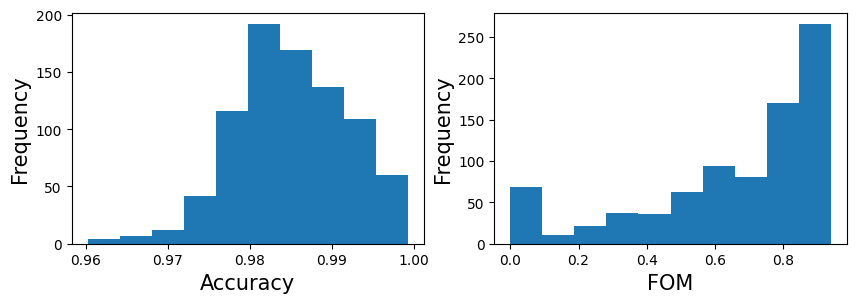

In [225]:
best_model_name = best_models.iloc[0]['name']
print(f"Best model: {best_model_name}")
best_model_path = os.path.join(model_file, best_model_name)
model, meta_data = get_model(best_model_path)

targets, test_preds = eval.get_preds(model,test_paths,batch_size=10)
print(len(test_preds))

test_metrics, test_arr = eval.eval_metrics(test_targets, test_preds)
eval.display_metrics(test_metrics, test_arr)


[0. 1.]


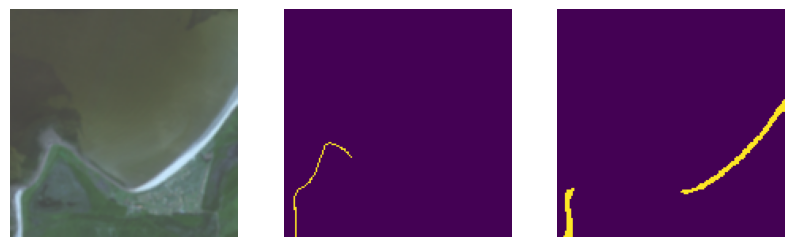

In [264]:
i = np.random.randint(0,len(test_paths))
rgb = utils.get_rgb(test_input[i],contrast=0.4)
target = test_targets[i]

pred = test_preds[i]
print(np.unique(pred))

fig, ax = plt.subplots(1,3,figsize=(10,4))
ax[0].imshow(rgb)
ax[1].imshow(target)
ax[2].imshow(pred)

for a in ax:
    a.axis('off')

Loading model: SIVE_02JUN2025_HED_BigEarthNet_False_DICE.pth

Using BigEarthNet pretrained ResNet-50
Backbone is trainable.
Side channels: [64, 256, 512, 1024, 2048]

Model metadata:
{'name': 'SIVE_02JUN2025_HED_BigEarthNet_False_DICE.pth', 'date': '02JUN2025', 'model_type': 'HED', 'backbone': ResNet50Backbone(
  (backbone): ResNet(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Module(
      (0): Module(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): Bat

/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:163: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP_ / (TP_ + FP_)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:165: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:164: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP_ / (TP_ + FN_)


accuracy: 99.4436
precision: 56.5645
recall: 72.0104
f1: 62.2551
iou: nan
fom: 89.8835


/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/SICS/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/SICS/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


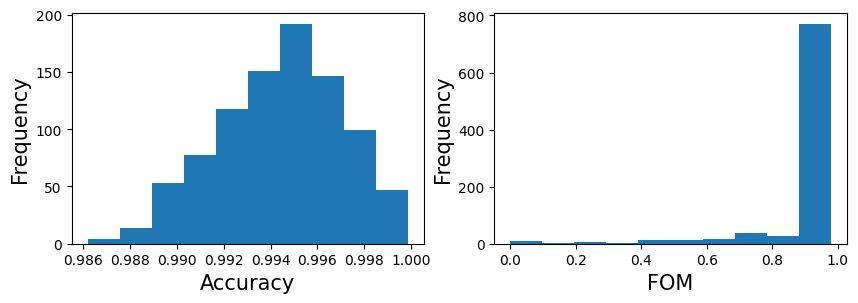

In [ ]:
model_path = model_paths[0]  # Use the first model found
model, meta_data = get_model(model_path)
print("Model metadata:")
print(meta_data)


targets, test_preds = eval.get_preds(model,test_paths,batch_size=10)
print(len(test_preds))
test_metrics, test_arr = eval.eval_metrics(test_targets, test_preds)

accuracy: 99.4436
precision: 56.5645
recall: 72.0104
f1: 62.2551
iou: nan
fom: 89.8835


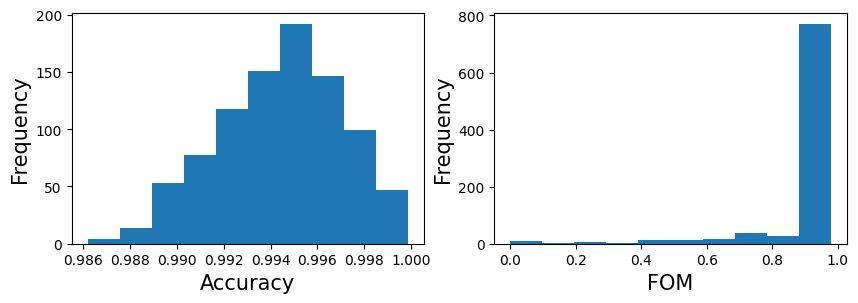

In [84]:
eval.display_metrics(test_metrics, test_arr)

# HED ImageNet

Using device: mps


Side channels: [16, 24, 80, 112, 320]
196


/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:164: RuntimeWarning: invalid value encountered in scalar divide
  recall = TP_ / (TP_ + FN_)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:165: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2 * (precision * recall) / (precision + recall)
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/src/evaluation.py:163: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP_ / (TP_ + FP_)


accuracy: 91.079
precision: 5.7618
recall: 92.5089
f1: 10.8272
iou: nan
fom: 44.8264


/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/SICS/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/SICS/lib/python3.11/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


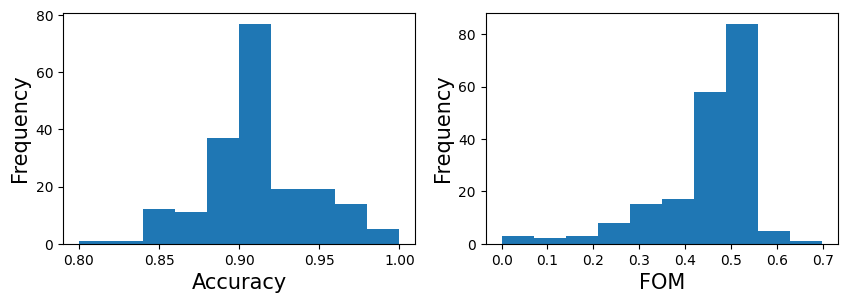

In [65]:
model_name = "SIVE_13MAR2025_HED_ImageNet_True_wBCE.pth"
device = torch.device('mps')  #UPDATE
print("Using device: {}\n".format(device))

backbone = hed.EfficientNetBackbone(in_channels=4)
model = hed.HED(backbone=backbone, out_channels=1)

state_dict = torch.load(f'../models/{model_name}', map_location=torch.device('cpu') )
model.load_state_dict(state_dict)
model.eval()
model.to(device)

targets, test_preds = eval.get_preds(model,test_paths,batch_size=10)
print(len(test_preds))

test_metrics, test_arr = eval.eval_metrics(test_targets, test_preds)
eval.display_metrics(test_metrics, test_arr)

[0. 1.]


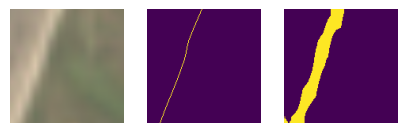

In [64]:
i = np.random.randint(0,len(test_paths))
rgb = utils.get_rgb(test_input[i],contrast=0.4)
target = test_targets[i]

pred = test_preds[i]
print(np.unique(pred))

fig, ax = plt.subplots(1,3,figsize=(5,2))
ax[0].imshow(rgb)
ax[1].imshow(target)
ax[2].imshow(pred)

for a in ax:
    a.axis('off')

# HED

Using device: mps

196
accuracy: 88.0097
precision: 4.6612
recall: 97.5202
f1: 8.8723
iou: nan
fom: 38.0964


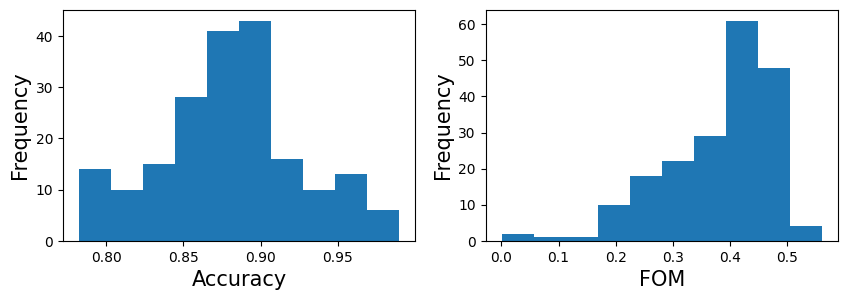

In [102]:
model_name = "SIVE_01MAR2025_HED_wBCE.pth"
device = torch.device('mps')  #UPDATE
print("Using device: {}\n".format(device))

backbone = hed.SimpleCNNBackbone(in_channels=4)
model = hed.HED(backbone=backbone, out_channels=1)

state_dict = torch.load(f'../models/{model_name}', map_location=torch.device('cpu') )
model.load_state_dict(state_dict)
model.eval()
model.to(device)

targets, test_preds = eval.get_preds(model,test_paths,batch_size=10)
print(len(test_preds))

test_metrics, test_arr = eval.eval_metrics(test_targets, test_preds)
eval.display_metrics(test_metrics, test_arr)

[0.]


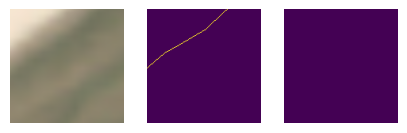

In [94]:
i = np.random.randint(0,len(test_paths))
rgb = utils.get_rgb(test_input[i],contrast=0.4)
target = test_targets[i]

pred = test_preds[i]
print(np.unique(pred))

fig, ax = plt.subplots(1,3,figsize=(5,2))
ax[0].imshow(rgb)
ax[1].imshow(target)
ax[2].imshow(pred)

for a in ax:
    a.axis('off')

# UNET

In [105]:
model_name = "SIVE_30APR2025_UNET_DICE.pth"
device = torch.device('mps')  #UPDATE
print("Using device: {}\n".format(device))

model = unet.U_Net(4, 1)

state_dict = torch.load(f'../models/{model_name}', map_location=torch.device('cpu') )
model.load_state_dict(state_dict)
model.eval()
model.to(device)

Using device: mps



U_Net(
  (Maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv1): conv_block(
    (conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (Conv2): conv_block(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )

In [106]:
targets, test_preds = eval.get_preds(model,test_paths,batch_size=10)
print(len(test_preds))

196


[0.]


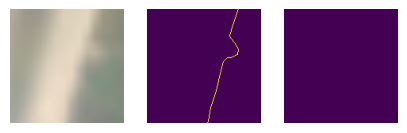

In [155]:
i = np.random.randint(0,len(test_paths))
rgb = utils.get_rgb(test_input[i],contrast=0.4)
target = test_targets[i]

pred = test_preds[i]
print(np.unique(pred))

fig, ax = plt.subplots(1,3,figsize=(5,2))
ax[0].imshow(rgb)
ax[1].imshow(target)
ax[2].imshow(pred)

for a in ax:
    a.axis('off')

accuracy: 98.5036
precision: 14.3917
recall: 40.3662
f1: 20.2995
iou: nan
fom: 63.5915


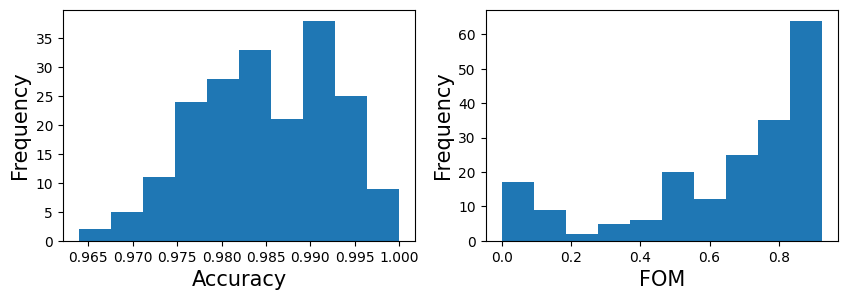

In [158]:
importlib.reload(eval)
test_metrics, test_arr = eval.eval_metrics(test_targets, test_preds)
eval.display_metrics(test_metrics, test_arr)